In [ ]:
image, mask = load_image_with_mask(data_root_path, "water_body_100.jpg")

In [ ]:
mask.shape

In [ ]:
show_image_mask(image,mask)

In [39]:
def show_image_mask_grid(images, masks):
    rows = (int((2*len(images))/2))
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(20,20))
    if rows == 1:
        axes[0].imshow(images[0])
        axes[1].imshow(masks[0])
    else:
        for row in range(rows):
            axes[row,0].imshow(images[row].numpy().transpose(1,2,0))
            axes[row,1].imshow(masks[row].numpy(),cmap=plt.get_cmap('gray'))

In [ ]:
show_image_mask_grid([(image,mask)])

In [ ]:
img_names = os.listdir(os.path.join(data_root_path,"Images"))
data = []
for name in img_names:
    data.append(load_image_with_mask(data_root_path, name))

In [ ]:
show_image_mask_grid(data[3:6])

In [ ]:
image_data = [img[0] for img in data]
mask_data = [img[1] for img in data]

In [ ]:
import torch.nn.functional as F
print(image_data[0].shape)
tmp_img = F.interpolate(image_data[0],size=(256))
tmp_mask = F.interpolate(mask_data[0],size=(256))
show_image_mask(tmp_img,tmp_mask)

In [ ]:
image_data = torch.Tensor(image_data)
mask_data = torch.Tensor(mask_data)

# start

In [1]:
import torch
from torchvision import transforms
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode
import os
import matplotlib.pyplot as plt
from typing import List,Tuple
import numpy as np
from PIL import Image

In [43]:
def show_image_mask(image,mask):
    img = image.numpy()
    img = img.transpose(1,2,0)
    
    msk = mask.numpy()
    #msk = msk.transpose(0,2)
    
    plt.imshow(img,figsize=(40,40))
    plt.show()
    plt.imshow(msk,cmap=plt.get_cmap('gray'),figsize=(40,40))
    plt.show()
    

In [2]:
data_root_path = "D:/AI_ML/Kaggle/Water Bodies Dataset/"

In [3]:
from torch.utils.data import *
class ImageMaskDataset(torch.utils.data.Dataset):
    def __init__(self, root:str,transform=None):
        self._image_data = os.path.join(root,"Images")
        self._mask_data = os.path.join(root,"Masks")
        self._filenames = os.listdir(self._image_data)
        self.transform = transform
        self._length = len(self._filenames)
    def __len__(self):
        return self._length
    
    def __getitem__(self, index):
        img_path = os.path.join(self._image_data, self._filenames[index])
        mask_path = os.path.join(self._mask_data, self._filenames[index])
        img = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask<100] = 0.0
        mask[mask>100] = 1.0
        
        #mask = mask.to(torch.float32)
        if self.transform:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations["image"]
            mask = augmentations["mask"]
        sample = (img, mask)
        return sample
    

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

tf = A.Compose(
[
    A.Resize(240,240),
    A.Normalize(
    mean=[0.0,0.0,0.0],
    std=[1.0,1.0,1.0],
    max_pixel_value=255.0),
    ToTensorV2()
])

water_dataset = ImageMaskDataset(data_root_path, tf)
print(len(water_dataset))

valid, train = random_split(water_dataset, [841,2000], generator=torch.Generator().manual_seed(42))

2841


tensor(0.7529) tensor(1.)
tensor(0.7255) tensor(1.)
tensor(0.7765) tensor(1.)
tensor(0.7255) tensor(1.)
tensor(0.7294) tensor(1.)
tensor(0.7451) tensor(1.)
tensor(0.7569) tensor(1.)
tensor(0.8196) tensor(1.)
tensor(0.8039) tensor(1.)
tensor(0.7765) tensor(1.)
tensor(0.7059) tensor(1.)
tensor(0.7176) tensor(1.)
tensor(0.7451) tensor(1.)
tensor(0.7059) tensor(1.)
tensor(0.7490) tensor(1.)
tensor(0.7059) tensor(1.)
tensor(0.7373) tensor(1.)
tensor(0.7686) tensor(1.)
tensor(0.7176) tensor(1.)
tensor(0.7255) tensor(1.)


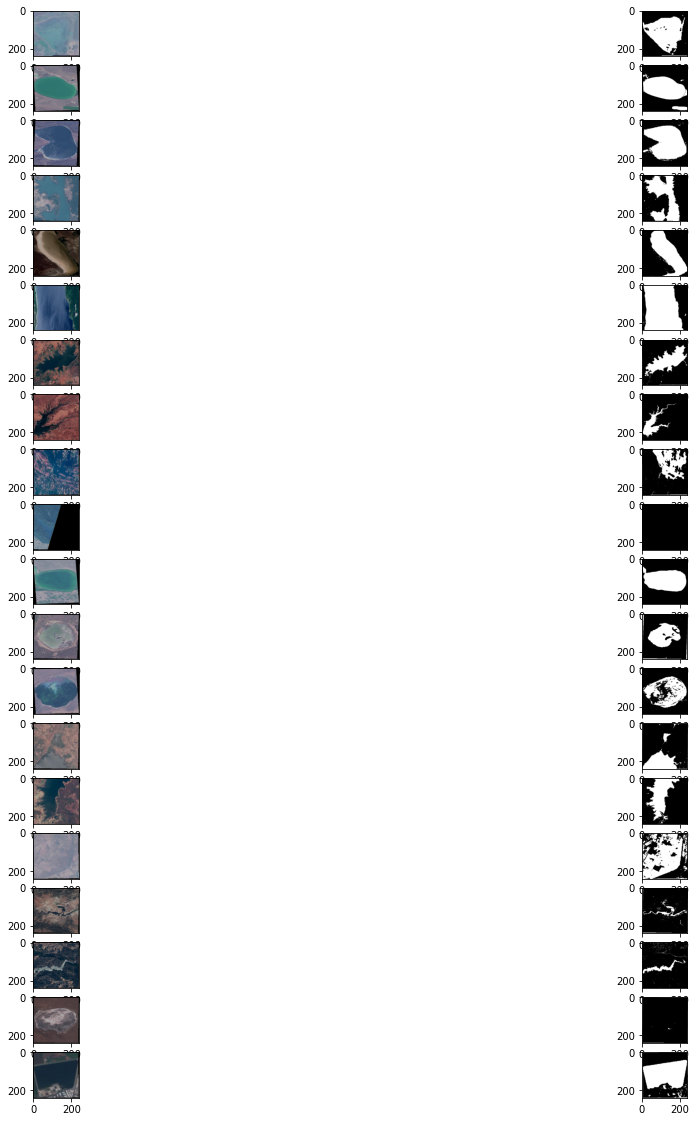

In [50]:
trainLoader = torch.utils.data.DataLoader(train, batch_size=20, shuffle=True, num_workers=0)
validLoader = torch.utils.data.DataLoader(valid, batch_size=29, shuffle=True, num_workers=0)

dataiter = iter(trainLoader)
images,labels = dataiter.next()
for i in range(len(images)):
    print(images[i].max(),labels[i].max())
show_image_mask_grid(images, labels)

#data = [(image,label) for image,label in zip(images,labels)]


In [85]:
import torch.nn as nn
import torch.nn.functional as F

class Unet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.initial = 5
        
        self.features = [2 ** x for x in range(self.initial, self.initial + 5)]
        self.features.insert(0, 3)
        print(type(self.features))
        self.downlayers = [self.double_conv(feat,self.features[i+1]) for i,feat in enumerate(self.features[:-2])]
        print(type(self.downlayers[0]))
        self.bottle_neck = self.double_conv(self.features[-2], self.features[-1]).cuda()
        
        self.uplayers = [self.double_conv(feat, self.features[i-1]) for i,feat in enumerate(reversed(self.features))]
#         self.up_layer1 = self.double_conv( 16*self.initial, 8*self.initial)
#         self.up_layer2 = self.double_conv( 8*self.initial, 4*self.initial)
#         self.up_layer3 = self.double_conv( 4*self.initial, 2*self.initial)
#         self.up_layer4 = self.double_conv( 2*self.initial, self.initial)

        
        #         self.down_layer1 = self.double_conv(3,self.initial)
#         self.down_layer2 = self.double_conv(self.initial,2*self.initial)
#         self.down_layer3 = self.double_conv(2*self.initial,4*self.initial)
#         self.down_layer4 = self.double_conv(4*self.initial,8*self.initial)
    def double_conv(self, in_features, out_features):
        layer = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_features, out_features, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True)
        )
        return layer
    
    def forward(self,x):

        #downsampling
        skip_connections = []
        for layer in self.downlayers:
            x = layer.cuda()(x)
            skip_connections.append(x)
            x = nn.MaxPool2d(2,2)(x)
        
        print(len(skip_connections))
        x = self.bottle_neck.cuda()(x)
        
        for i,layer in enumerate(self.uplayers):
            i+=1
            print(self.features[(-i)], self.features[(-i-1)])
            x = nn.ConvTranspose2d(self.features[(-i)],self.features[(-i-1)], 2,2).cuda()(x)
            x = torch.cat([skip_connections[i-1], x],1)
            x = layer.cuda()(x)
#         upsample = nn.ConvTranspose2d(16*self.initial,8*self.initial,2,2).cuda()(bottleneck)
#         cat_upsample1 = torch.cat([upsample, down4],1)
#         #print(cat_upsample1.shape)
#         upscale1 = self.up_layer1(cat_upsample1)
        
#         #print(upscale1.shape)
#         upsample = nn.ConvTranspose2d(8*self.initial,4*self.initial,2,2).cuda()(upscale1)
#         upscale2 = self.up_layer2(torch.cat([upsample, down3], 1))
#         #print(upscale2.shape)
#         upsample = nn.ConvTranspose2d(4*self.initial,2*self.initial,2,2).cuda()(upscale2)
#         upscale3 = self.up_layer3(torch.cat([upsample, down2], 1))
#         #print(upscale3.shape)
#         upsample = nn.ConvTranspose2d(2*self.initial,1*self.initial,2,2).cuda()(upscale3)
#         upscale4 = self.up_layer4(torch.cat([upsample, down1], 1))
#         #print(upscale4.shape)
        x = nn.Conv2d(1*self.initial,1,1).cuda()(x)
        
        return x
#         down1 = self.down_layer1(x)
#         down1_s = nn.MaxPool2d(2,2)(down1)
#         #print(down1.shape, down1_s.shape)
#         down2 = self.down_layer2(down1_s)
#         down2_s = nn.MaxPool2d(2,2)(down2)
#         #print(down2.shape, down2_s.shape)
#         down3 = self.down_layer3(down2_s)
#         down3_s = nn.MaxPool2d(2,2)(down3)
#         #print(down3.shape, down3_s.shape)
#         down4 = self.down_layer4(down3_s)
#         down4_s = nn.MaxPool2d(2,2)(down4)
#         #print(down4.shape,down4_s.shape)
#         #print("----------------------")
#         bottleneck = self.bottle_neck(down4_s)
        #print(bottleneck.shape, bottleneck.dtype)
        #print("----------------------")

    #         for layer in self.net:
#             x = layer(x)
#         print(x.size())
#         return x
    
unet = Unet()
from torchsummary import summary
summary(unet.to('cuda'),(3,572,572))
unet.to('cuda')


<class 'list'>
<class 'torch.nn.modules.container.Sequential'>
4
512 256


RuntimeError: Sizes of tensors must match except in dimension 2. Got 70 and 572 (The offending index is 0)

In [69]:
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(unet.parameters(), lr=1e-5)


In [70]:
scaler = torch.cuda.amp.GradScaler() #???????????? czemu uzycie tego pozwolilo zadzialac xddddd
train_losses = []
val_losses = []
for epoch in range(10):
    #learning phase
    running_loss = 0.0
    valid_loss = 0.0
    for i,data in enumerate(trainLoader, 0):
        inputs, masks = data[0].to("cuda"), data[1].to('cuda').unsqueeze(1)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():#????????????????????
            pred = unet(inputs)
            loss = criterion(pred, masks)
        running_loss += loss.item()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    train_losses.append(running_loss/len(trainLoader))
    
    #validation phase
    for i,data in enumerate(validLoader):
        inputs, labels = data[0].to("cuda"), data[1].to("cuda").unsqueeze(1)
        
        with torch.no_grad():
            pred = unet(inputs)
            loss = criterion(pred, labels)
        valid_loss += loss.item()
    val_losses.append(valid_loss/len(validLoader))
    
    print(f'{epoch +1} train_loss: {train_losses[-1]} valid loss: {val_losses[-1]} ')

RuntimeError: Given groups=1, weight of size [64, 32, 3, 3], expected input[20, 3, 240, 240] to have 32 channels, but got 3 channels instead

In [ ]:
data = iter(validLoader).next()

unet.eval()
out = unet(data[0][0].unsqueeze(0).to("cuda"))


In [ ]:
print(out.shape)
#show_image_mask(data[0][0], out.detach().squeeze(0).squeeze(0).to("cpu"))
show_image_mask(data[0][0], data[1][0])

In [ ]:
def load_image_with_mask(path:str,img_name:str):
    image = read_image(os.path.join(path, "Images",img_name))
    mask = read_image(os.path.join(path, "Masks", img_name))
    return (image, mask)